In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260125_random.csv"
DATE_COL = "experiment_date"

TARGET_WEEKS = [pd.Timestamp("2026-01-05")]

Y_COLS = ["nonrepeat_cnt_per_user", "trip_cnt_per_user"]

CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

NUM_FEATURES = [
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "nonrepeat_cnt_per_user_lag2",
    "nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2",
    "trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2",
    "weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2",
    "weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2",
    "weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2",
    "weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2",
    "weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2",
    "weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2",
    "coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2",
    "coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2",
    "coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2",
    "coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2",
    "coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2",
    "coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2",
    "coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2",
    "coupon_daily_per_user_log1p_roll4",
]

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()

# 只保留到最大 target week 為止（後面不會用到）
df = df[df[DATE_COL] <= max(TARGET_WEEKS)].copy()

# categorical cast
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

# feature availability check
missing_num = [c for c in NUM_FEATURES if c not in df.columns]
missing_cat = [c for c in CAT_COLS if c not in df.columns]
if missing_cat:
    print("[WARN] Missing categorical cols (will be dropped):", missing_cat)
if missing_num:
    print("[WARN] Missing numeric features (will be dropped):", missing_num)

X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred) -> float:
    return float(mean_absolute_error(y_true, y_pred))

def fit_predict_one_week(df_all: pd.DataFrame, target_week: pd.Timestamp, y_col: str):
    # 嚴格遵守：只能拿 target_week 之前的資料訓練
    train_df = df_all[df_all[DATE_COL] < target_week].copy()
    test_df  = df_all[df_all[DATE_COL] == target_week].copy()

    # drop rows with missing target
    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        return None, None, len(train_df), len(test_df)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    y_test = test_df[y_col].astype(float)

    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=2000,
        learning_rate=0.06,
        num_leaves=63,
        min_child_samples=300,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=5.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )

    # categorical_feature: 用欄名即可
    model.fit(X_train, y_train, categorical_feature=[c for c in CAT_IN_X if c in X_train.columns])

    y_pred = model.predict(X_test)
    return y_test.values, y_pred, len(train_df), len(test_df)

# --------------------------
# Run + Print metrics
# --------------------------
for y_col in Y_COLS:
    print(f"\n==================== {y_col} ====================")
    all_y_true = []
    all_y_pred = []

    for tw in TARGET_WEEKS:
        y_true, y_pred, n_tr, n_te = fit_predict_one_week(df, tw, y_col)
        if y_true is None:
            print(f"[{tw.date()}] SKIP (train_rows={n_tr:,}, test_rows={n_te:,})")
            continue

        r = rmse(y_true, y_pred)
        m = mae(y_true, y_pred)
        print(f"[{tw.date()}] train_rows={n_tr:,} test_rows={n_te:,}  RMSE={r:.6f}  MAE={m:.6f}")

        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

    if all_y_true:
        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)
        print(f"[Overall] test_rows={len(all_y_true):,}  RMSE={rmse(all_y_true, all_y_pred):.6f}  MAE={mae(all_y_true, all_y_pred):.6f}")



==================== nonrepeat_cnt_per_user ====================
[2026-01-05] train_rows=2,112 test_rows=192  RMSE=0.046948  MAE=0.034872
[Overall] test_rows=192  RMSE=0.046948  MAE=0.034872

==================== trip_cnt_per_user ====================
[2026-01-05] train_rows=2,112 test_rows=192  RMSE=0.036859  MAE=0.027855
[Overall] test_rows=192  RMSE=0.036859  MAE=0.027855


In [9]:
# ==========================
# Optuna tuning for RANDOM (treatment+source+ops_type_merged+city_group in model)
# - Target week: 2026-01-05
# - Train uses STRICTLY before 2026-01-05
# - Tune separately for each y in Y_COLS
# - Objective: RMSE on 2026-01-05
# - No saving files
# ==========================

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

TEST_WEEK = pd.Timestamp("2026-01-05")

BASE_PARAMS = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=63,
    min_child_samples=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=5.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

def fit_predict_one_week_with_params(df_all: pd.DataFrame, target_week: pd.Timestamp, y_col: str, model_params: dict):
    train_df = df_all[df_all[DATE_COL] < target_week].copy()
    test_df  = df_all[df_all[DATE_COL] == target_week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        return None, None, len(train_df), len(test_df)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    y_test = test_df[y_col].astype(float)

    model = lgb.LGBMRegressor(**model_params)
    model.fit(
        X_train, y_train,
        categorical_feature=[c for c in CAT_IN_X if c in X_train.columns],
    )
    y_pred = model.predict(X_test)
    return y_test.values, y_pred, len(train_df), len(test_df)

def tune_one_target(y_col: str, n_trials: int = 60):
    def objective(trial: optuna.Trial) -> float:
        params = dict(BASE_PARAMS)

        # --- search space around current setup (and generally sensible)
        params["learning_rate"] = trial.suggest_float("learning_rate", 0.030, 0.055, log=True)
        params["n_estimators"]  = trial.suggest_int("n_estimators", 1200, 3600, step=200)

        params["num_leaves"] = trial.suggest_int("num_leaves", 31, 255, step=8)
        params["min_child_samples"] = trial.suggest_int("min_child_samples", 50, 600, step=25)

        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0, step=0.05)
        params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.05)

        params["reg_alpha"] = trial.suggest_float("reg_alpha", 0.0, 5.0)
        params["reg_lambda"] = trial.suggest_float("reg_lambda", 0.0, 15.0)

        y_true, y_pred, n_tr, n_te = fit_predict_one_week_with_params(df, TEST_WEEK, y_col, params)
        if y_true is None or len(y_true) == 0:
            return 1e9

        score = rmse(y_true, y_pred)
        trial.report(score, step=1)
        return float(score)

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\n===== Optuna Best ({y_col}) =====")
    print("Best RMSE:", study.best_value)
    print("Best params:", study.best_params)

    best_params = dict(BASE_PARAMS)
    best_params.update(study.best_params)

    # evaluate best with RMSE + MAE
    y_true, y_pred, n_tr, n_te = fit_predict_one_week_with_params(df, TEST_WEEK, y_col, best_params)
    print(
        f"[{TEST_WEEK.date()}][{y_col}] train_rows={n_tr:,} test_rows={n_te:,} "
        f"RMSE={rmse(y_true, y_pred):.6f} MAE={mae(y_true, y_pred):.6f}"
    )

    return study

# --------------------------
# Run tuning separately for two targets
# --------------------------
study_nonrepeat = tune_one_target("nonrepeat_cnt_per_user", n_trials=60)
study_trip      = tune_one_target("trip_cnt_per_user", n_trials=60)


  0%|          | 0/60 [00:00<?, ?it/s]


===== Optuna Best (nonrepeat_cnt_per_user) =====
Best RMSE: 0.04399207797452211
Best params: {'learning_rate': 0.0391040113156135, 'n_estimators': 2800, 'num_leaves': 135, 'min_child_samples': 375, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 3.5776539119291915, 'reg_lambda': 11.722401573115551}
[2026-01-05][nonrepeat_cnt_per_user] train_rows=2,112 test_rows=192 RMSE=0.043992 MAE=0.033630


  0%|          | 0/60 [00:00<?, ?it/s]


===== Optuna Best (trip_cnt_per_user) =====
Best RMSE: 0.03610189360396376
Best params: {'learning_rate': 0.032960977245010084, 'n_estimators': 1800, 'num_leaves': 183, 'min_child_samples': 450, 'subsample': 0.6, 'colsample_bytree': 0.95, 'reg_alpha': 2.000132701890499, 'reg_lambda': 14.059408693826233}
[2026-01-05][trip_cnt_per_user] train_rows=2,112 test_rows=192 RMSE=0.036102 MAE=0.027868


In [10]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# ==========================
# Build prediction table CSV for 2026-01-05 (RANDOM)
# - Grain: (experiment_date, treatment, source, ops_type_merged, city_group)
# - Values: actual + baseline(lag1/roll4) + LGBM preds (from Optuna best params)
# - If duplicated keys exist: simple mean (unweighted)
# ==========================

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260125_random.csv"   # 你的路徑

DATE_COL = "experiment_date"
TEST_WEEK = pd.Timestamp("2026-01-05")

KEY_COLS = ["experiment_date", "treatment", "source", "ops_type_merged", "city_group"]

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# baseline columns (你說沒錯，就用這些)
Y1_LAG1_COL = "trip_cnt_per_user_lag1"
Y1_ROLL4_COL = "trip_cnt_per_user_roll4"
Y2_LAG1_COL = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4_COL = "nonrepeat_cnt_per_user_roll4"

CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

NUM_FEATURES = [
    "avg_rainy_day","avg_rainy_weekday","avg_rainy_weekend","mgm_day",
    "nonrepeat_cnt_per_user_lag2","nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2","trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2","weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2","weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2","weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2","weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2","weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2","weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2","coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2","coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2","coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2","coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2","coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2","coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2","coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2","coupon_daily_per_user_log1p_roll4",
]

OUT_PATH = "../../result/random_v2/random_predictions_full_v2.csv"

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()
df = df[df[DATE_COL] <= TEST_WEEK].copy()

# categorical cast
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

# feature availability check
missing_num = [c for c in NUM_FEATURES if c not in df.columns]
missing_cat = [c for c in CAT_COLS if c not in df.columns]
if missing_cat:
    print("[WARN] Missing categorical cols (will be dropped):", missing_cat)
if missing_num:
    print("[WARN] Missing numeric features (will be dropped):", missing_num)

X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

for col in [Y1_LAG1_COL, Y1_ROLL4_COL, Y2_LAG1_COL, Y2_ROLL4_COL]:
    if col not in df.columns:
        print(f"[WARN] Baseline column missing: {col} (will be NaN in output)")

# --------------------------
# Utils
# --------------------------
def align_categories(train_df: pd.DataFrame, test_df: pd.DataFrame, cat_cols):
    # test categories 強制沿用 train 的 categories
    for c in cat_cols:
        if c in train_df.columns and c in test_df.columns:
            train_df[c] = train_df[c].astype("category")
            test_df[c] = test_df[c].astype("category")
            test_df[c] = test_df[c].cat.set_categories(train_df[c].cat.categories)
    return train_df, test_df

def fit_predict(df_all: pd.DataFrame, week: pd.Timestamp, y_col: str, params: dict):
    train_df = df_all[df_all[DATE_COL] < week].copy()
    test_df  = df_all[df_all[DATE_COL] == week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    # align categories
    train_df, test_df = align_categories(train_df, test_df, CAT_IN_X)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, categorical_feature=[c for c in CAT_IN_X if c in X_train.columns])

    pred = model.predict(X_test)
    return test_df, pred

# --------------------------
# Get best params from Optuna studies
# (你已經跑完 tune_one_target 會有 study_trip / study_nonrepeat)
# --------------------------
try:
    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
    best_params_y1 = dict(base_params)
    best_params_y1.update(study_trip.best_params)          # trip_cnt_per_user
    best_params_y2 = dict(base_params)
    best_params_y2.update(study_nonrepeat.best_params)     # nonrepeat_cnt_per_user
except NameError:
    raise NameError(
        "找不到 study_trip / study_nonrepeat。\n"
        "請確認你已經先跑完 optuna，或把 best_params dict 直接貼到 best_params_y1 / best_params_y2。"
    )

# --------------------------
# Predict
# --------------------------
test_y1_df, pred_y1 = fit_predict(df, TEST_WEEK, Y1, best_params_y1)
test_y2_df, pred_y2 = fit_predict(df, TEST_WEEK, Y2, best_params_y2)

# keep only needed cols + rename
cols_y1 = [c for c in KEY_COLS if c in test_y1_df.columns] + [Y1, Y1_LAG1_COL, Y1_ROLL4_COL]
cols_y1 = [c for c in cols_y1 if c in test_y1_df.columns]
tmp1 = test_y1_df[cols_y1].copy()
tmp1.rename(columns={
    DATE_COL: "experiment_date",
    Y1: "trip_cnt_per_user",
    Y1_LAG1_COL: "pred_y1_lag1",
    Y1_ROLL4_COL: "pred_y1_roll4",
}, inplace=True)
tmp1["pred_y1_lgbm"] = pred_y1

cols_y2 = [c for c in KEY_COLS if c in test_y2_df.columns] + [Y2, Y2_LAG1_COL, Y2_ROLL4_COL]
cols_y2 = [c for c in cols_y2 if c in test_y2_df.columns]
tmp2 = test_y2_df[cols_y2].copy()
tmp2.rename(columns={
    DATE_COL: "experiment_date",
    Y2: "nonrepeat_cnt_per_user",
    Y2_LAG1_COL: "pred_y2_lag1",
    Y2_ROLL4_COL: "pred_y2_roll4",
}, inplace=True)
tmp2["pred_y2_lgbm"] = pred_y2

# outer merge (handles missingness differences between Y1/Y2 rows)
on_cols = [c for c in KEY_COLS if c in tmp1.columns and c in tmp2.columns]
out = tmp1.merge(tmp2, on=on_cols, how="outer")

# --------------------------
# If duplicate keys exist -> simple mean (unweighted)
# --------------------------
need_cols = [
    "trip_cnt_per_user","pred_y1_lag1","pred_y1_roll4","pred_y1_lgbm",
    "nonrepeat_cnt_per_user","pred_y2_lag1","pred_y2_roll4","pred_y2_lgbm",
]
exist_cols = [c for c in need_cols if c in out.columns]

out = (
    out.groupby(KEY_COLS, as_index=False)[exist_cols]
       .mean()
)

# --------------------------
# Column order exactly as you requested
# --------------------------
final_cols = [
    "experiment_date","treatment","source","ops_type_merged","city_group",
    "trip_cnt_per_user","pred_y1_lag1","pred_y1_roll4","pred_y1_lgbm",
    "nonrepeat_cnt_per_user","pred_y2_lag1","pred_y2_roll4","pred_y2_lgbm",
]
for c in final_cols:
    if c not in out.columns:
        out[c] = np.nan

out = out[final_cols].sort_values(KEY_COLS).reset_index(drop=True)

# --------------------------
# Save CSV
# --------------------------
out.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("Saved:", OUT_PATH)


Saved: ../../result/random_v2/random_predictions_full_v2.csv


/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_56022/1846320196.py:180: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out.groupby(KEY_COLS, as_index=False)[exist_cols]


/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_56022/1603402740.py:86: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


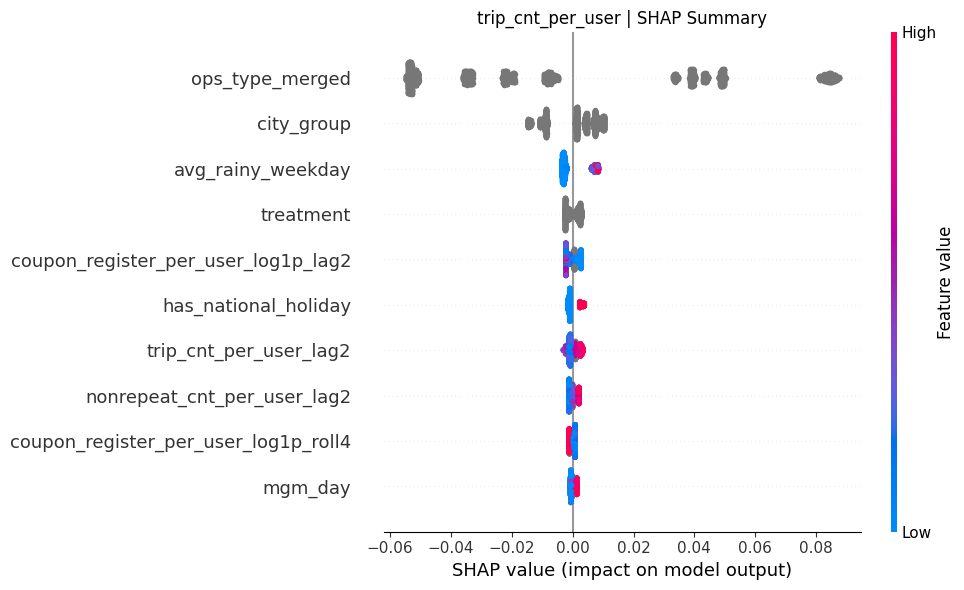

/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_56022/1603402740.py:99: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


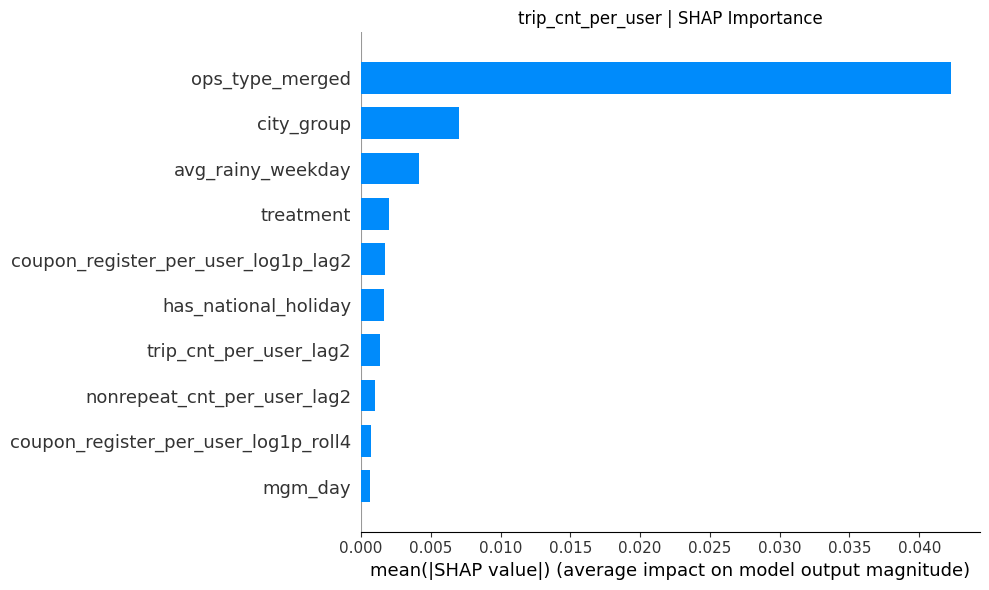

/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_56022/1603402740.py:86: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


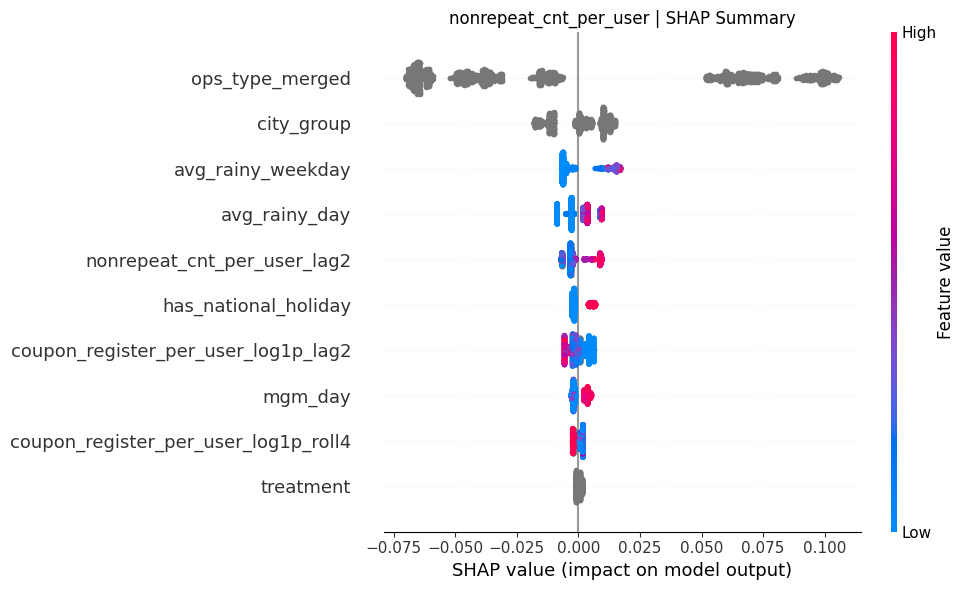

/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_56022/1603402740.py:99: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


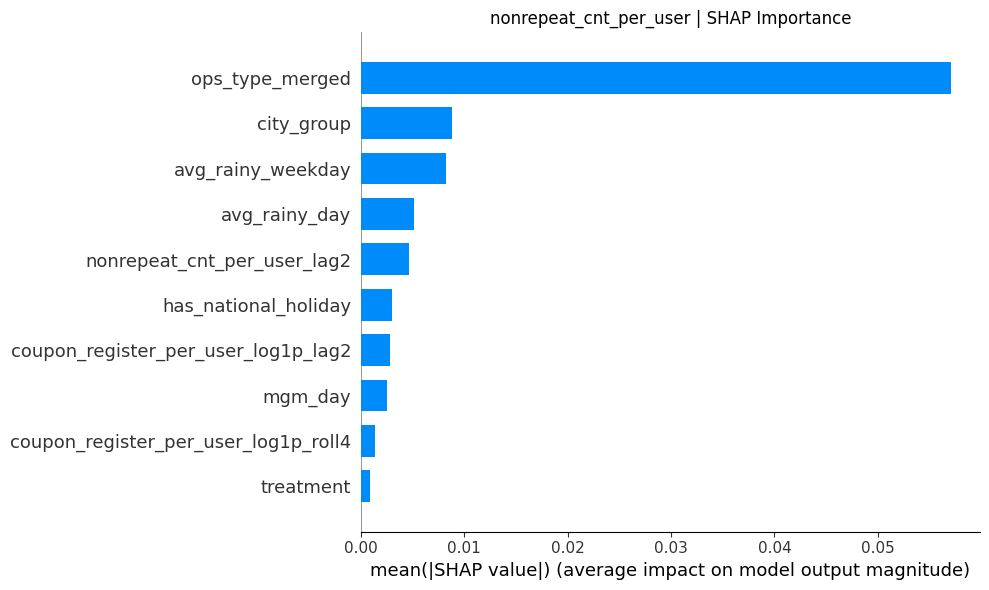

In [11]:
# ==========================
# SHAP on the FULL TRAINING SET (包含訓練資料)
# - Train: all data strictly before 2026-01-05
# - SHAP: computed on X_train (full)
# - Uses Optuna best params: study_trip / study_nonrepeat
# ==========================

import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

# --------------------------
# Assumes you already have:
# - df, DATE_COL, TEST_WEEK
# - X_COLS, CAT_IN_X
# - study_trip, study_nonrepeat
# - (and your RANDOM setting where CAT_COLS includes treatment/source/ops_type_merged/city_group)
# --------------------------

# If shap not installed, uncomment:
# !pip -q install shap

# ---- make plots deterministic-ish
np.random.seed(42)

# ---- build train/test split
train_df = df[df[DATE_COL] < TEST_WEEK].copy()
test_df  = df[df[DATE_COL] == TEST_WEEK].copy()

def align_categories(train_df: pd.DataFrame, test_df: pd.DataFrame, cat_cols):
    for c in cat_cols:
        if c in train_df.columns and c in test_df.columns:
            train_df[c] = train_df[c].astype("category")
            test_df[c]  = test_df[c].astype("category")
            test_df[c]  = test_df[c].cat.set_categories(train_df[c].cat.categories)
    return train_df, test_df

train_df, test_df = align_categories(train_df, test_df, CAT_IN_X)

X_train = train_df[X_COLS]
X_test  = test_df[X_COLS]

# ✅ 你要「包含訓練資料」：這裡就用整個 X_train 來算 SHAP
X_explain = X_train

# 如果你想連 test 也一起解釋（train+test），改成：
# X_explain = pd.concat([X_train, X_test], axis=0)

# --------------------------
# Base params used in your Optuna tuning script
# --------------------------
BASE_PARAMS = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=63,
    min_child_samples=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=5.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

def fit_best_model(y_col: str, study) -> lgb.LGBMRegressor:
    best_params = dict(BASE_PARAMS)
    best_params.update(study.best_params)   # ✅ optuna 最佳參數覆蓋進來
    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        X_train,
        train_df[y_col].astype(float),
        categorical_feature=[c for c in CAT_IN_X if c in X_train.columns],
    )
    return model

def plot_shap(model, X_explain: pd.DataFrame, title_prefix: str):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_explain)

    # 1) Beeswarm
    plt.figure()
    shap.summary_plot(
        shap_values,
        X_explain,
        show=False,
        plot_size=(10, 6),
        max_display=10,  # 想多顯示就調大
    )
    plt.title(f"{title_prefix} | SHAP Summary")
    plt.tight_layout()
    plt.show()

    # 2) Bar (mean |SHAP|)
    plt.figure()
    shap.summary_plot(
        shap_values,
        X_explain,
        plot_type="bar",
        show=False,
        plot_size=(10, 6),
        max_display=10,
    )
    plt.title(f"{title_prefix} | SHAP Importance")
    plt.tight_layout()
    plt.show()

# --------------------------
# Run for both targets (RANDOM)
# --------------------------
model_trip = fit_best_model("trip_cnt_per_user", study_trip)
plot_shap(model_trip, X_explain, "trip_cnt_per_user")

model_nonrepeat = fit_best_model("nonrepeat_cnt_per_user", study_nonrepeat)
plot_shap(model_nonrepeat, X_explain, "nonrepeat_cnt_per_user")
